In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Config
input_length = 3001
latent_dim = 128
batch_size = 64
epochs = 15

# Path split
splits_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\splits"
train_manifest = os.path.join(splits_root, "train.csv")
test_manifest  = os.path.join(splits_root, "test.csv")


In [2]:
import sys
print(sys.executable)


e:\Skripsi\DEC\envTA\Scripts\python.exe


In [3]:
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
Built with CUDA: False
GPU devices: []


In [4]:
def load_waveform(path):
    st = read(path)
    tr = st[0].data.astype(np.float32)
    return tr

def load_dataset(manifest_csv):
    df = pd.read_csv(manifest_csv)
    X = [load_waveform(p) for p in df["path"]]
    X = np.array(X)
    X = np.expand_dims(X, -1)   # shape (N, 3001, 1)
    return X, df["label"].values


In [5]:
X_train, y_train = load_dataset(train_manifest)
X_test, y_test   = load_dataset(test_manifest)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (3861, 3001, 1)
Test shape : (966, 3001, 1)


In [41]:
def build_autoencoder(input_length, latent_dim):
    inp = keras.Input(shape=(input_length,1))

    # === Encoder ===
    x = layers.Conv1D(16, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)   # ~1500
    x = layers.Conv1D(32, 7, padding="same", activation="relu",kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = layers.MaxPooling1D(2)(x)   # ~750
    x = layers.Dropout(0.1)(x)
    x = layers.Conv1D(64, 7, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)   # ~375

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # === Decoder ===
    x = layers.Dense((input_length//8)*64)(latent)
    x = layers.Reshape((input_length//8, 64))(x)

    x = layers.Conv1DTranspose(32, 7, strides=2, padding="same", activation="relu")(x) # ~750
    x = layers.Conv1DTranspose(16, 7, strides=2, padding="same", activation="relu")(x) # ~1500
    x = layers.Conv1DTranspose(1, 7, strides=2, padding="same")(x)                     # ~3000

    x = layers.ZeroPadding1D(padding=(0,1))(x)   # dari 3000 → 3001

    model = keras.Model(inp, x, name="CAE")
    encoder = keras.Model(inp, latent, name="Encoder")
    return model, encoder


In [42]:
model, encoder = build_autoencoder(input_length, latent_dim)
latent_dim = encoder.output_shape[1]
print(f"Encoder loaded. Latent dim = {latent_dim}")


Encoder loaded. Latent dim = 128


In [43]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint("best_ae.h5", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)
# Simpan hanya encoder
encoder = keras.Model(model.input, model.get_layer("latent").output)
encoder.save("encoder.h5")

Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.9271 - val_loss: 0.8213
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.7685 - val_loss: 0.7030
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.6571 - val_loss: 0.6304
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 0.5739 - val_loss: 0.5971
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.5048 - val_loss: 0.5911
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.4363 - val_loss: 0.6021
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.3684 - val_loss: 0.6218
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.3112 - val_loss: 0.6426
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.2678 - val_loss: 0.6573
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.2339 - val_loss: 0.6757
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 0.2066 - val_loss: 0.6907
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step

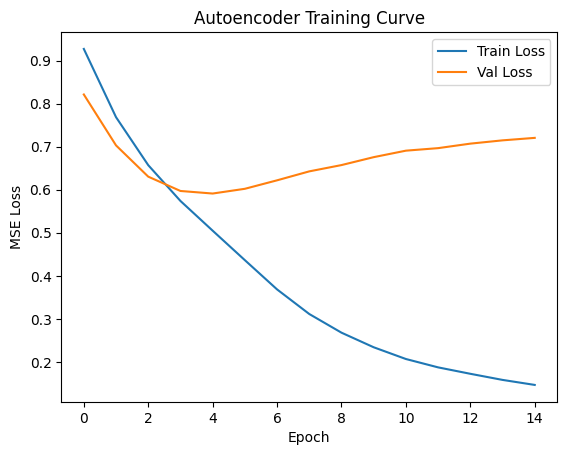

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Text(0.5, 1.0, 'input vs recon')

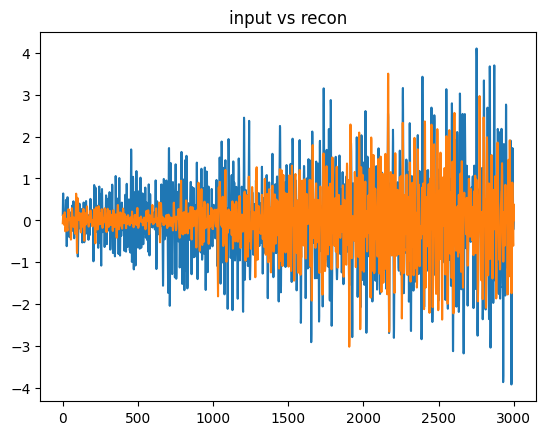

In [46]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Autoencoder Training Curve")
plt.show()

recon = model.predict(X_test[:100])
plt.plot(X_test[0].squeeze()); plt.plot(recon[0].squeeze()); plt.title("input vs recon")
